In [1]:
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, norm
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'

# Input data directory
GT_DIR = '/path/to/your/input/data/directory/'
GEN_DIR = '/path/to/your/output/data/directory/'

CXR_LABELS_1 = ["Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Lesion", 
"Lung Opacity", "Edema", "Consolidation", "Pneumonia", 
"Atelectasis", "Pneumothorax", "Pleural Effusion", "Pleural Other", "Fracture", "Support Devices"] # without "No Finding"

In [2]:
import warnings
warnings.filterwarnings('ignore')

## 1. Prepare Data

Exclude "No Finding"

In [3]:
df_gen = pd.read_csv(GEN_DIR+'gen_labels_sample_2_1.csv').sort_values(by='study_id').reset_index(drop=True) ## 2-class
df_gen.dropna(inplace=True)
df_gen.shape

(300, 15)

In [4]:
df_gt = pd.read_csv(GT_DIR+"gt_labels_sample.csv").sort_values(by='study_id').reset_index(drop=True)
df_gt.dropna(inplace=True)
df_gt.shape

(300, 15)

In [5]:
df_gt = df_gt[df_gt['study_id'].isin(df_gen['study_id'])]
df_gt.shape

(300, 15)

In [6]:
df_temp = df_gt.drop(columns=["study_id", "No Finding"])
df_temp.columns == CXR_LABELS_1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [7]:
# GT label distribution
df = df_gt.drop(columns=['study_id'])
df_counts = pd.DataFrame(columns=CXR_LABELS_1)

for col in CXR_LABELS_1:
    temp = df[col].value_counts()
    df_counts[col] = temp

df_counts = df_counts.fillna(0).T
df_counts.rename(columns={2: 'unmentioned', 1: 'positive', 0: 'negative', -1: 'uncertain'}, inplace=True)
df_counts_gt = df_counts[['positive', 'negative', 'uncertain', 'unmentioned']]
df_counts_gt['Pr(pos)'] = df_counts_gt['positive'] / 300
df_counts_gt

,positive,negative,uncertain,unmentioned,Pr(pos)
Enlarged Cardiomediastinum,10.0,4.0,14.0,272.0,0.033333
Cardiomegaly,52.0,17.0,13.0,218.0,0.173333
Lung Lesion,5.0,2.0,2.0,291.0,0.016667
Lung Opacity,60.0,1.0,1.0,238.0,0.200000
Edema,35.0,42.0,15.0,208.0,0.116667
Consolidation,10.0,17.0,5.0,268.0,0.033333
Pneumonia,7.0,37.0,24.0,232.0,0.023333
Atelectasis,57.0,1.0,14.0,228.0,0.190000
Pneumothorax,7.0,45.0,3.0,245.0,0.023333
Pleural Effusion,65.0,30.0,3.0,202.0,0.216667


In [8]:
# GT label distribution (classify into different condition groups)
ls_gt_corr = []
df_gt_corr = pd.DataFrame(columns=CXR_LABELS_1)
df_contingency_gt = pd.DataFrame(columns=CXR_LABELS_1)
for i in range(len(CXR_LABELS_1)):

    df = df_gt.drop(columns=['study_id'])
    df = df[df[CXR_LABELS_1[i]] == 1]

    df_counts = pd.DataFrame(index=[0, 1, 2, -1], columns=CXR_LABELS_1).fillna(0)

    for lbl in CXR_LABELS_1:
        temp = df[lbl].value_counts()
        df_counts.loc[temp.index, lbl] = temp
    

    df_counts = df_counts.fillna(0).T
    df_counts.rename(columns={2: 'unmentioned', 1: 'positive', 0: 'negative', -1: 'uncertain'}, inplace=True)
   
    df_counts_gt_e = df_counts[['positive', 'negative', 'uncertain', 'unmentioned']]
    df_counts_gt_e['Pr(pos)'] = df_counts_gt_e['positive'] / (df_counts_gt_e['positive']+df_counts_gt_e['negative']+df_counts_gt_e['uncertain']+df_counts_gt_e['unmentioned'])
    
    ls_gt = df_counts_gt['Pr(pos)']
    ls_e = df_counts_gt_e['Pr(pos)']
    ls_gt_corr.append(ls_gt.corr(ls_e))
    df_gt_corr[CXR_LABELS_1[i]] = ls_e
    df_contingency_gt[CXR_LABELS_1[i]] = df_counts_gt_e['positive']

df_gt_corr['Overall'] = ls_gt


In [9]:
# Gen label distribution
df = df_gen.drop(columns=['study_id'])
df_counts = pd.DataFrame(columns=CXR_LABELS_1)

for col in CXR_LABELS_1:
    temp = df[col].value_counts()
    df_counts[col] = temp

df_counts = df_counts.fillna(0).T
df_counts.rename(columns={1: 'positive', 0: 'other'}, inplace=True)
df_counts_gen_2_o = df_counts[['positive', 'other']]
df_counts_gen_2_o['Pr(pos)'] = df_counts_gen_2_o['positive'] / (df_counts_gen_2_o['positive']+df_counts_gen_2_o['other'])
df_counts_gen_2_o

,positive,other,Pr(pos)
Enlarged Cardiomediastinum,62.0,238.0,0.206667
Cardiomegaly,224.0,76.0,0.746667
Lung Lesion,1.0,299.0,0.003333
Lung Opacity,234.0,66.0,0.780000
Edema,46.0,254.0,0.153333
Consolidation,18.0,282.0,0.060000
Pneumonia,6.0,294.0,0.020000
Atelectasis,69.0,231.0,0.230000
Pneumothorax,6.0,294.0,0.020000
Pleural Effusion,190.0,110.0,0.633333


In [10]:
# Gen label distribution (classify into different condition groups)
ls_gen_corr = []
df_corr = pd.DataFrame(columns=CXR_LABELS_1)
df_contingency_gen = pd.DataFrame(columns=CXR_LABELS_1)
for i in range(len(CXR_LABELS_1)):

    df = df_gen.copy()
    df = df_gen[df_gen['study_id'].isin(df_gt[df_gt[CXR_LABELS_1[i]] == 1]['study_id'])]
    df = df.drop(columns=['study_id'])

    df_counts = pd.DataFrame(index=[0, 1, 2, -1], columns=CXR_LABELS_1).fillna(0)

    for lbl in CXR_LABELS_1:
        temp = df[lbl].value_counts()
        df_counts.loc[temp.index, lbl] = temp
    

    df_counts = df_counts.fillna(0).T
    df_counts.rename(columns={1: 'positive', 0: 'other'}, inplace=True)
    df_counts_gen_e = df_counts[['positive', 'other']]
    df_counts_gen_e['Pr(pos)'] = df_counts_gen_e['positive'] / (df_counts_gen_e['positive']+df_counts_gen_e['other'])
    
    ls_gen = df_counts_gen_2_o['Pr(pos)']
    ls_e = df_counts_gen_e['Pr(pos)']
    ls_gen_corr.append(ls_gen.corr(ls_e))
    df_corr[CXR_LABELS_1[i]] = ls_e
    df_contingency_gen[CXR_LABELS_1[i]] = df_counts_gen_e['positive']

df_corr['Overall'] = ls_gen

# 2. Chi-square Test

## Method 1: Replace zero value with a very small value

In [11]:
df_temp_gt = (df_contingency_gt*1000+1)/1000
chi2, p, dof, expected = chi2_contingency(df_temp_gt)
print(f"Chi-square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"df: {dof}")

df_temp_gen = (df_contingency_gen*1000+1)/1000
chi2, p, dof, expected = chi2_contingency(df_temp_gen)
print(f"Chi-square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"df: {dof}")

Chi-square Statistic: 1770.3807917073586
P-value: 8.182797696116892e-278
df: 144
Chi-square Statistic: 74.24530530049316
P-value: 0.99999974439841
df: 144


## Method 2: Drop zero values

In [12]:
ls_condition = ['Cardiomegaly', 'Edema', 'Lung Opacity', 'Atelectasis', 'Pleural Effusion', "Support Devices"] # Top 6 conditions in subsample

In [13]:
df_temp = df_contingency_gt[ls_condition]
df_temp_gt = df_temp[df_contingency_gt.index.isin(ls_condition)]

df_temp = df_contingency_gen[ls_condition]
df_temp_gen = df_temp[df_contingency_gen.index.isin(ls_condition)]

In [14]:
chi2, p, dof, expected = chi2_contingency(df_temp_gt)
print(f"Chi-square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"df: {dof}")

chi2, p, dof, expected = chi2_contingency(df_temp_gen)
print(f"Chi-square Statistic: {chi2}")
print(f"P-value: {p}")
print(f"df: {dof}")

Chi-square Statistic: 317.8608472683398
P-value: 1.5397305563780617e-52
df: 25
Chi-square Statistic: 6.106490104308666
P-value: 0.9999593206960198
df: 25


# 3. Bootstrap CI

In [15]:
def bootstrap_confidence_interval(df, num_bootstrap_samples=1000, ci=95):
    bootstrap_samples = []
    # Resampling with replacement and computing the statistic of interest
    for _ in range(num_bootstrap_samples):
        idx = np.random.choice(df.shape[0], size=df.shape[0], replace=True)
        df_bootstrap = df[df.index.isin(idx)]
        df_bootstrap_con = df_bootstrap[df_bootstrap['gt']==1]
        Pr_pos_con = sum(df_bootstrap_con['gen']==1) / df_bootstrap_con.shape[0]
        Pr_pos = sum(df_bootstrap['gen']==1) / df_bootstrap.shape[0]
        bootstrap_samples.append(Pr_pos_con-Pr_pos)

    # Calculating the confidence interval
    lower_percentile = (100 - ci) / 2
    upper_percentile = 100 - lower_percentile
    confidence_lower = round(np.percentile(bootstrap_samples, lower_percentile), 3)
    confidence_upper = round(np.percentile(bootstrap_samples, upper_percentile), 3)
    
    return confidence_lower, confidence_upper, bootstrap_samples


In [16]:
dict_ci = {}

for i in range(len(ls_condition)):
    df_temp = pd.DataFrame(columns=['gt', 'gen'])
    df_temp['gt'] = df_gt[ls_condition[i]]
    dict_ci[ls_condition[i]] = {'labels': [], 'ci': []}
    for j in range(len(ls_condition)):
        if ls_condition[i] == ls_condition[j]:
            continue
        df_temp['gen'] = df_gen[ls_condition[j]]
        ci_lower, ci_upper, _ = bootstrap_confidence_interval(df_temp, 1000, 95)
        dict_ci[ls_condition[i]]['labels'].append(ls_condition[j])
        dict_ci[ls_condition[i]]['ci'].append((ci_lower, ci_upper))
        print(f"95% Confidence Interval of {ls_condition[i]} and {ls_condition[j]}: [{ci_lower}, {ci_upper}]")
    print('----------------------------------------')


95% Confidence Interval of Cardiomegaly and Edema: [-0.116, 0.003]
95% Confidence Interval of Cardiomegaly and Lung Opacity: [-0.055, 0.103]
95% Confidence Interval of Cardiomegaly and Atelectasis: [-0.065, 0.103]
95% Confidence Interval of Cardiomegaly and Pleural Effusion: [-0.026, 0.15]
95% Confidence Interval of Cardiomegaly and Support Devices: [0.153, 0.317]
----------------------------------------
95% Confidence Interval of Edema and Cardiomegaly: [-0.116, 0.102]
95% Confidence Interval of Edema and Lung Opacity: [0.032, 0.192]
95% Confidence Interval of Edema and Atelectasis: [-0.15, 0.031]
95% Confidence Interval of Edema and Pleural Effusion: [-0.024, 0.207]
95% Confidence Interval of Edema and Support Devices: [0.124, 0.319]
----------------------------------------
95% Confidence Interval of Lung Opacity and Cardiomegaly: [-0.092, 0.065]
95% Confidence Interval of Lung Opacity and Edema: [-0.041, 0.098]
95% Confidence Interval of Lung Opacity and Atelectasis: [-0.088, 0.06]


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


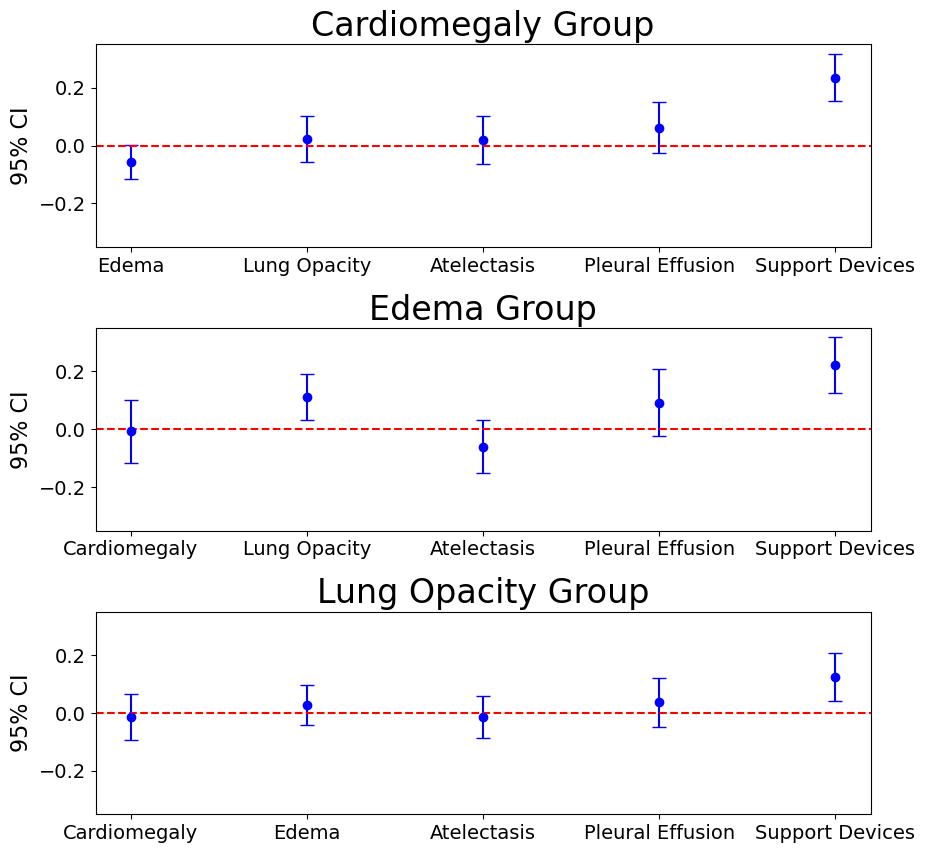

In [17]:
data = {k: dict_ci[k] for k in list(dict_ci)[:3]}

fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for idx, (condition, values) in enumerate(data.items()):
    labels = values['labels']
    ci_lower = [ci[0] for ci in values['ci']]
    ci_upper = [ci[1] for ci in values['ci']]
    y_pos = range(len(labels))

    axs[idx].errorbar(labels, [(l+u)/2 for l, u in zip(ci_lower, ci_upper)], 
                      yerr=[[abs(l-(l+u)/2) for l, u in zip(ci_lower, ci_upper)], 
                            [u-(l+u)/2 for l, u in zip(ci_lower, ci_upper)]], 
                      fmt='o', capsize=5, color='blue')
    
    axs[idx].set_title(f'{condition} Group', fontsize=24)
    axs[idx].axhline(y=0, color='red', linestyle='--')
    axs[idx].set_ylabel('95% CI', fontsize=16)
    axs[idx].set_ylim(-0.35, 0.35)
    axs[idx].tick_params(axis='both', which='major', labelsize=14)

plt.subplots_adjust(hspace=0.4)
plt.show()


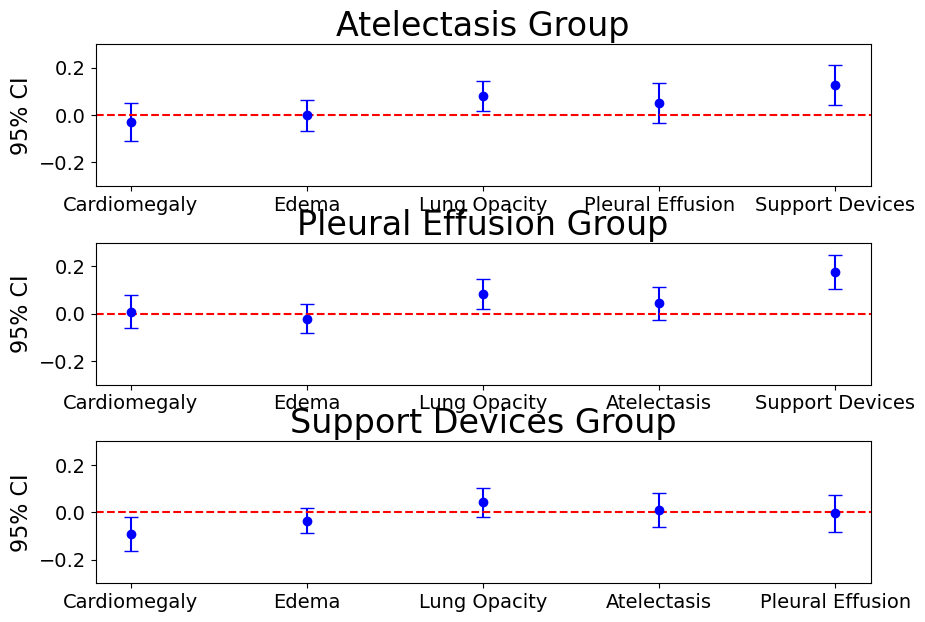

In [18]:
data = {k: dict_ci[k] for k in list(dict_ci)[3:]}

fig, axs = plt.subplots(3, 1, figsize=(10, 7))

for idx, (condition, values) in enumerate(data.items()):
    labels = values['labels']
    ci_lower = [ci[0] for ci in values['ci']]
    ci_upper = [ci[1] for ci in values['ci']]
    y_pos = range(len(labels))

    axs[idx].errorbar(labels, [(l+u)/2 for l, u in zip(ci_lower, ci_upper)], 
                      yerr=[[abs(l-(l+u)/2) for l, u in zip(ci_lower, ci_upper)], 
                            [u-(l+u)/2 for l, u in zip(ci_lower, ci_upper)]], 
                      fmt='o', capsize=5, color='blue')
    
    axs[idx].set_title(f'{condition} Group', fontsize=24)
    axs[idx].axhline(y=0, color='red', linestyle='--')
    axs[idx].set_ylabel('95% CI', fontsize=16)
    axs[idx].set_ylim(-0.3, 0.3)
    axs[idx].tick_params(axis='both', which='major', labelsize=14)

plt.subplots_adjust(hspace=0.4)
plt.show()

# 4. Correlation Test

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


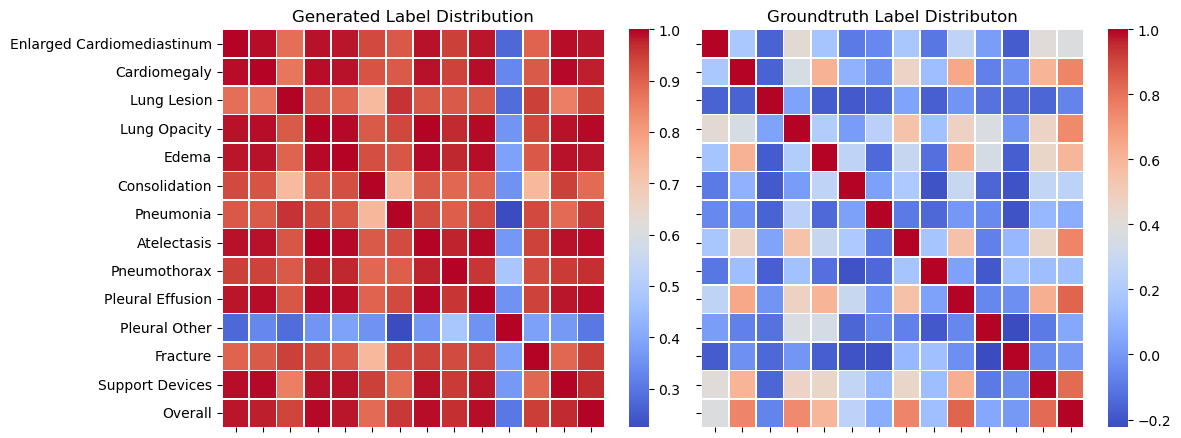

In [19]:
corr_matrix1 = df_corr.corr()
corr_matrix2 = df_gt_corr.corr()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

sns.heatmap(corr_matrix1, ax=ax1, annot=False, cmap='coolwarm', fmt=".1f", linewidths=.5)
ax1.set_title('Generated Label Distribution')
ax1.set_xticklabels([])
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)

sns.heatmap(corr_matrix2, ax=ax2, annot=False, cmap='coolwarm', fmt=".1f", linewidths=.5)
ax2.set_title('Groundtruth Label Distributon')
ax2.set_xticklabels([])
ax2.set_yticklabels([])

plt.tight_layout()
plt.show()